### APS 1052 Final Project

The focus of the team's model is going to be the seed model from the book Machine Learning and Data Science Blueprints for Finance. The model is going to be using stock data provided via the Google Drive, sub-folder > IntraDayData > TradeAndQuoteETFData. The goal of our model is to use the stock regression model provided from the book to predict the future price of an ETF. 


In addition to Lasso Regression model, our team processes to xgboost method to obtain better prediction accuracy

In [1]:
# Load libraries
import numpy as np
import pandas as pd

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor



#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [3]:
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import spearmanr
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import fAux
import detrendPrice

In [4]:
# stocks
appl_data = pd.read_csv('AAPL.csv')
jpm_data = pd.read_csv('JPM.csv')
msft_data = pd.read_csv('MSFT.csv') 
amzn_data = pd.read_csv('AMZN.csv')

# ETFs
spy_data = pd.read_csv('SPY.csv')
qqq_data = pd.read_csv('QQQ.csv')
ief_data = pd.read_csv('IEF.csv')
# indices 
vix_data = pd.read_csv('^VIX.csv')
dia_data = pd.read_csv('DIA.csv')
sp500_data = pd.read_csv('SP500.csv')

# predicting stock (y-variable)
ivv_data = pd.read_csv('IVV.csv')

In [5]:
# function to clean the data 
# changes dates to datetime format & ensures all numbers are type float64 
def clean_data(df): 
    cleaned_df = pd.DataFrame()
    cleaned_df["Date"] = pd.to_datetime(df.iloc[:, 0])
    cleaned_df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(str).astype(float)
    return cleaned_df
 
    
df_list = [appl_data, jpm_data, msft_data, amzn_data, spy_data, qqq_data,
        vix_data, dia_data, sp500_data, ivv_data]

# iterates through list of all dataframes and cleans format 
for stock in df_list: 
    df = pd.DataFrame()
    df = clean_data(stock)
    stock = df

In [6]:
stk_tickers = ['AAPL', 'JPM', 'MSFT','AMZN']
etf_tickers = ['SPY', 'QQQ']
idx_tickers = ['SP500', 'DIA','^VIX']

In [7]:
import talib as ta
def get_indicator(df,indicator):
    ret_df = df
    timeperiod = 5
    if 'MACD' in indicator: #Moving Average Convergence Divergence
        macd, macdsignal, macdhist = ta.MACD(df.Close.values, fastperiod=12, slowperiod=26, signalperiod=9)
        ret_df = ret_df.join(pd.DataFrame([macd, macdsignal, macdhist]).T.rename(columns={0: "Macddif", 1: "Macddem", 2: "Macdhist"}))
    if 'MFI' in indicator: 
        mfi = ta.MFI(np.reshape(df.High.values.astype('float64'),-1), \
            np.reshape(df.Low.values.astype('float64'),-1), np.reshape(df.Close.values.astype('float64'),-1),\
                 np.reshape(df.Volume.values.astype('float64'),-1), timeperiod=timeperiod)
        ret_df = ret_df.join(pd.DataFrame([mfi]).T.rename(columns={0: "Mfi"}))
    if 'SMA' in indicator: 
        sma = ta.SMA(df.Close.values)
        ret_df = ret_df.join(pd.DataFrame([sma]).T.rename(columns={0: "Sma"}))
    if 'MOM' in indicator: 
        mom = ta.MOM(df.Close.values, timeperiod=timeperiod)
        ret_df = ret_df.join(pd.DataFrame([mom]).T.rename(columns={0: "Mom"}))  
    if 'ROC' in indicator: 
        roc = ta.ROC(df.Close.values, timeperiod=timeperiod)
        ret_df = ret_df.join(pd.DataFrame([roc]).T.rename(columns={0: "Roc"}))  
    if 'RSI' in indicator: 
        rsi = ta.RSI(df.Close.values, timeperiod=timeperiod)
        ret_df = ret_df.join(pd.DataFrame([rsi]).T.rename(columns={0: "Rsi"}))  
    if 'ATR' in indicator: #Volatility Indicator   -   Average True Range
        rsi = ta.ATR(df.High.values,df.Low.values,df.Close.values, timeperiod=timeperiod)
        ret_df = ret_df.join(pd.DataFrame([rsi]).T.rename(columns={0: "Atr"}))  
    return ret_df

In [8]:
#### TECHNICAL INDICATOR ########################################################################################################### 
#### LAGS 

# create function to calculate lags based on return period (value can be changed)
return_period = 5

def calc_general_lag(df):
    temp = pd.DataFrame(np.log(df["Adj Close"]).diff(return_period).shift(-return_period))
    return temp

# iterate through entire list except for ivv_data 
appended_data = []
for stock in df_list:
    temp = calc_general_lag(stock)
    appended_data.append(temp)


dataset = pd.DataFrame()
dataset = pd.concat(appended_data, axis=1)
col_names = ["AAPL", "JPM", "MSFT", "AMZN", "SPY", "QQQ", "VIX", "DIA", "SP500", "IVV_pred"]
dataset.columns = col_names


# calculate lags specifically for the y-variable (IVV) - lags are in multiples of 3 
ivv_lags = pd.concat([np.log(ivv_data["Adj Close"]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*10]], axis=1)
ivv_lags.columns = ["IVV_" + str(return_period), "IVV_" + str(return_period*3), "IVV_" + str(return_period*6), "IVV_" + str(return_period*10)]

# full dataset with all X and Y variables 
full_data = pd.concat([dataset, ivv_lags], axis=1).dropna().iloc[::return_period, :]

# data description 
data_descrip = full_data.describe()


# set the X and Y variables 
CopyX = full_data[["IVV_pred"]].copy()
Y = full_data[["IVV_pred"]].reset_index(drop= True)
X = full_data.loc[:, full_data.columns != 'IVV_pred'].reset_index(drop= True)

In [9]:
# calculate mfi using yahoo data
p1=pd.DataFrame(np.log(spy_data['Adj Close']))
p2=pd.DataFrame(np.log(ief_data['Adj Close']))
mfi=(p1.subtract(p2).dropna())
mfi=mfi.rolling(20).mean()
mfi.columns = ['Mfi']
X = X.join(mfi)

In [10]:
ivv = get_indicator(ivv_data, ['SMA','RSI','ROC','MOM','ATR'])
X = X.join(ivv.iloc[:,-5:])
X = X.fillna(X.mean())
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [11]:
pipe = Pipeline([("scaler", StandardScaler()), ("PCA", PCA()), ('xgb', xgb.XGBRegressor(verbosity=0))])

# Parameters for GridSearch
n_estimators  = [50, 100]
max_depth = [1, 3, 6, 50]
learning_rate = [0.1, 0.3, 0.8]
objective = ['reg:squarederror']
booster = ['gbtree', 'gblinear', 'dart']
gamma = [0, 1, 20]
base_score = [0.2, 0.5 ,0.7]
subsample = [0.2, 0.5, 1]
sampling_method = ['uniform', 'gradient_based']
tree_method = ['auto', 'exact', 'approx', 'hist']
min_child_weight = [0, 1, 5, 10]
max_delta_step = [0, 1, 20, 50]
n_components = [1, 2]

# parameter grid 
para_grid = {'xgb__n_estimators': n_estimators,
            'xgb__max_depth': max_depth,
            'xgb__learning_rate': learning_rate,
            'xgb__objective': objective,
            'xgb__booster': booster,
            'xgb__gamma': gamma,
            'xgb__base_score': base_score,
            'xgb__subsample': subsample,
            'xgb__sampling_method': sampling_method,
            'xgb__tree_method': tree_method,
            'xgb__min_child_weight': min_child_weight,
            'xgb__max_delta_step': max_delta_step,
            'PCA__n_components': n_components
            }

print('Parameter grid: {}' .format(para_grid))

Parameter grid: {'xgb__n_estimators': [50, 100], 'xgb__max_depth': [1, 3, 6, 50], 'xgb__learning_rate': [0.1, 0.3, 0.8], 'xgb__objective': ['reg:squarederror'], 'xgb__booster': ['gbtree', 'gblinear', 'dart'], 'xgb__gamma': [0, 1, 20], 'xgb__base_score': [0.2, 0.5, 0.7], 'xgb__subsample': [0.2, 0.5, 1], 'xgb__sampling_method': ['uniform', 'gradient_based'], 'xgb__tree_method': ['auto', 'exact', 'approx', 'hist'], 'xgb__min_child_weight': [0, 1, 5, 10], 'xgb__max_delta_step': [0, 1, 20, 50], 'PCA__n_components': [1, 2]}


In [12]:
from sklearn.metrics import r2_score
np.random.seed(2)
#Fit the randomized search object with Xtrain and ytrain.ravel()
rso = RandomizedSearchCV(pipe,
                         para_grid,
                         n_iter= 10,
                         random_state = 20,
                         scoring = make_scorer(r2_score, greater_is_better=True),
                         )

# Fit the model to find the best hyperparameter values
rso.fit(x_train, y_train)

print('Best parameters:', rso.best_params_)
print("rso best score: ", rso.best_score_) 

Best parameters: {'xgb__tree_method': 'hist', 'xgb__subsample': 0.5, 'xgb__sampling_method': 'uniform', 'xgb__objective': 'reg:squarederror', 'xgb__n_estimators': 100, 'xgb__min_child_weight': 0, 'xgb__max_depth': 3, 'xgb__max_delta_step': 0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 1, 'xgb__booster': 'gblinear', 'xgb__base_score': 0.2, 'PCA__n_components': 2}
rso best score:  0.9352639410451484


In [13]:
best_xgb = xgb.XGBRegressor(tree_method='hist', subsample=0.5, sampling_method='uniform',
                            objective='reg:squarederror', n_estimators=100,
                            min_child_weight=0, max_depth=3, max_delta_step=0,
                            learning_rate=0.1, gamma=1, booster='gblinear',
                            base_score=0.2)

In [14]:
scaler = StandardScaler()
scaler.fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

# PCA the features
pca = PCA(n_components=2)
pca.fit(x_train)
X_train = pca.transform(x_train)
X_test = pca.transform(x_test)

best_xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.2, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=6,
             num_parallel_tree=None, predictor=None, random_state=0,
             reg_alpha=0, reg_lambda=0, sampling_method='uniform',
             scale_pos_weight=1, subsample=0.5, tree_method='hist',
             validate_parameters=1, verbosity=None)

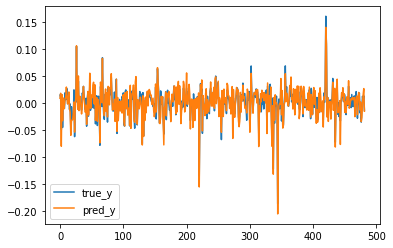

In [15]:
true_y = y_test.values.ravel()
pred_y = best_xgb.predict(x_test)

from matplotlib import pyplot
pyplot.plot(true_y, label='true_y')
pyplot.plot(pred_y, label='pred_y')
pyplot.legend()
pyplot.show()

In [16]:
df_ret = ivv_data.iloc[CopyX.index.values]['Adj Close'].pct_change(periods=1).fillna(0)
df_ret1 = df_ret.reset_index(drop= True)[:x_train.shape[0],]
df_ret2 = df_ret.reset_index(drop= True)[x_train.shape[0]:,]

In [17]:
positions = np.where(best_xgb.predict(x_train)> 0,1,-1 ) 
dailyRet = pd.Series(positions).shift(1).fillna(0).values * df_ret1
dailyRet = dailyRet.fillna(0)
cumret = np.array(np.cumprod(dailyRet + 1) - 1)

rho, pval = spearmanr(y_test,best_xgb.predict(x_test)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret[-1]) ** ((253/5) / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = ((253/5) ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6} Rho={:0.6} PVal={:0.6}\n'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


In-sample: CAGR=0.063852 Sharpe ratio=0.424616 maxDD=-0.407317 maxDDD=240 Calmar ratio=0.156762 Rho=0.846102 PVal=2.95501e-133



In [18]:
positions2 = np.where(best_xgb.predict(x_test)> 0,1,-1 )
dailyRet2 = pd.Series(positions2).shift(1).fillna(0).values * df_ret2
dailyRet2 = dailyRet2.fillna(0)
cumret2 = np.array(np.cumprod(dailyRet2 + 1) - 1)

rho, pval = spearmanr(y_test,best_xgb.predict(x_test)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret2[-1]) ** ((253/5) / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = ((253/5) ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


Out-of-sample: CAGR=-0.102242 Sharpe ratio=-0.637432 maxDD=-0.66224 maxDDD=358 Calmar ratio=-0.154388  Rho=0.846102 PVal=2.95501e-133



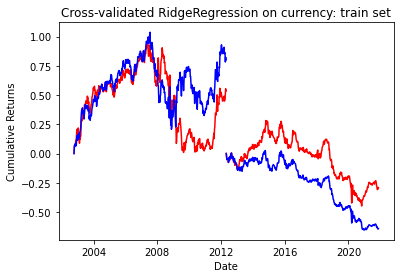

In [19]:
positionsytrain = np.where(y_train.values.ravel() > 0,1,-1 )
dailyRetytrain = pd.Series(positionsytrain).shift(1).fillna(0).values * df_ret1
dailyRetytrain = dailyRetytrain.fillna(0)
cumretytrain = np.array(np.cumprod(dailyRetytrain + 1) - 1)



positionsytest = np.where(y_test.values.ravel() > 0,1,-1 )
dailyRetytest = pd.Series(positionsytest).shift(1).fillna(0).values * df_ret2
dailyRetytest = dailyRetytest.fillna(0)
cumretytest = np.array(np.cumprod(dailyRetytest + 1) - 1)



dates = df.iloc[CopyX.index.values]['Date']
dates= dates.reset_index(drop= True)[:x_train.shape[0],]
pyplot.figure(1)
pyplot.plot(dates, cumretytrain ,'r')
pyplot.plot(dates, cumret,'b')
pyplot.title('Cross-validated RidgeRegression on currency: train set')
pyplot.ylabel('Cumulative Returns')
pyplot.xlabel('Date')
dates = df.iloc[CopyX.index.values]['Date']
dates= dates.reset_index(drop= True)[x_train.shape[0]:,]
pyplot.plot(dates, cumretytest ,'r')
pyplot.plot(dates, cumret2,'b')



average return 0.000546
[-0.01150837  0.01780078]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.41759999999999997


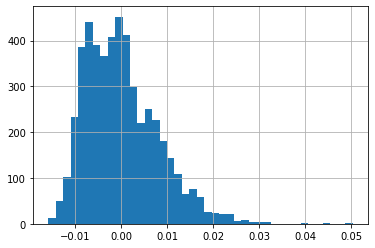

In [20]:
import WhiteRealityCheckFor1
#white reality check

new_close=ivv_data.iloc[CopyX.index.values]['Adj Close'].reset_index(drop= True)[(x_train.shape[0]):,]
detrended_close = detrendPrice.detrendPrice(new_close)
detrended_ret1 = detrended_close.pct_change(periods=1).fillna(0)
detrended_syst_rets = detrended_ret1 * pd.Series(positions2).shift(1).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
pyplot.show()


In [21]:
# Train error
train_result = mean_squared_error(best_xgb.predict(x_train), y_train)
test_result = mean_squared_error(best_xgb.predict(x_test), y_test)

#train_perc = "{:.0%}".format(train_result)
#test_perc = "{:.0%}".format(test_result)
#print(train_perc, test_perc)
print(train_result, test_result)


0.00012389815815181735 0.0001341770340652076
